In [30]:
import numpy as np
import pandas as pd
from bayes_opt import BayesianOptimization
import sklearn 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
df = pd.read_excel('data/All Data combined.xlsx')
df

,Unnamed: 0,number of trials,number of parameters,type of function,accuracy [calc. max/ actual max],time per trial [s],type_of_opt,assigned_class
0,0.0,16,2,Trig,0.732417,0.009824,CmaEs,0
1,1.0,13,2,Trig,0.983980,0.008316,CmaEs,0
2,2.0,10,2,Trig,0.638160,0.007854,CmaEs,0
3,3.0,18,2,Trig,0.952784,0.009196,CmaEs,0
4,4.0,11,2,Trig,0.284646,0.007938,CmaEs,0
...,...,...,...,...,...,...,...,...
1345,NaN,8,2,Trig,0.034904,0.007662,CMA-ES,0
1346,NaN,8,2,Trig,0.091423,0.010617,CMA-ES,0
1347,NaN,14,2,Trig,0.015566,0.019561,CMA-ES,0
1348,NaN,9,2,Trig,0.076210,0.011982,CMA-ES,0


In [3]:
df = df.drop(['Unnamed: 0'], axis=1)
df = df.drop(['type_of_opt'], axis=1)

In [4]:
df = df[df['accuracy [calc. max/ actual max]'] < 1.05]  

In [5]:
x = df[['number of trials','number of parameters','accuracy [calc. max/ actual max]', 'time per trial [s]']].values

In [6]:
#df['type_of_opt'].replace('CmaEs', 1,inplace=True)
#df['type_of_opt'].replace('Random', 2,inplace=True)
#df['type_of_opt'].replace('TPE', 3,inplace=True)
y = df['assigned_class']

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.30)

In [8]:
x_train = StandardScaler().fit(x_train).transform(x_train)
x_test = StandardScaler().fit(x_test).transform(x_test)
x_train = MinMaxScaler().fit(x_train).transform(x_train)
x_test = MinMaxScaler().fit(x_test).transform(x_test)

In [9]:
y_train = np.asarray(y_train)

In [10]:
x_train.shape

(933, 4)

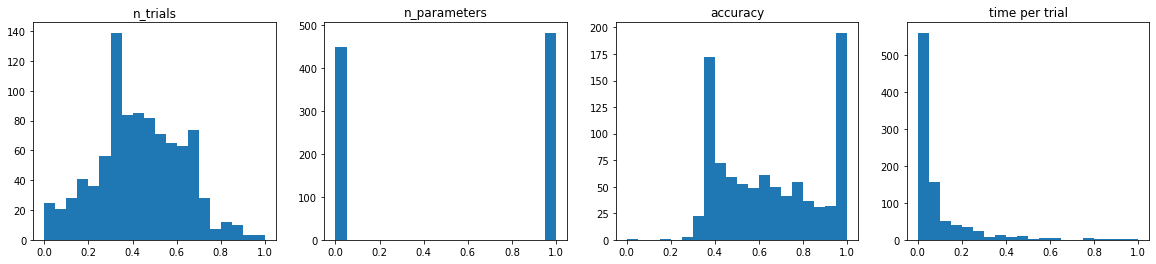

In [11]:
fig, ax = plt.subplots(figsize=(20,4), ncols = 4)
ax[0].hist(x_train[:,0], bins = 20)
ax[0].set_title('n_trials')
ax[1].hist(x_train[:,1], bins = 20)
ax[1].set_title('n_parameters')
ax[2].hist(x_train[:,2], bins = 20)
ax[2].set_title('accuracy')
ax[3].hist(x_train[:,3], bins = 20)
ax[3].set_title('time per trial')
plt.show()


## Using a Decision Tree Classifier 

In [12]:
def func(x,y):
    estimator = DecisionTreeClassifier(max_depth= int(np.round(x)))
    clf = BaggingClassifier(base_estimator=estimator, n_estimators= int(np.round(y)))
    clf = clf.fit(x_train, y_train)
    yhat = clf.predict(x_test)
    MSE = mean_squared_error(y_test, yhat)
    acc = accuracy_score(y_test, yhat)
    
    return  acc



xmin = 1
xmax = 50
ymin = 1
ymax = 50

pbounds = {'x': (xmin, xmax), 'y': (ymin, ymax)}

optimizer = BayesianOptimization(f=func, pbounds=pbounds, verbose=3)

optimizer.maximize(init_points = 20, n_iter = 30)
    
best_params = optimizer.max["params"]
    
found_x = best_params['x']
found_y = best_params['y']

max_value = func(found_x, found_y)
    
print("Found x: {}, f: {}".format(found_x, (func(found_x, found_y))))
print("Found y: {}, f: {}".format(found_y, (func(found_x, found_y))))
print("Max value found is: {}".format(max_value))

|   iter    |  target   |     x     |     y     |
-------------------------------------------------
|  1        |  0.6035   |  33.5     |  25.78    |
|  2        |  0.5885   |  4.202    |  49.22    |
|  3        |  0.596    |  37.69    |  5.346    |
|  4        |  0.6185   |  34.92    |  32.77    |
|  5        |  0.6135   |  41.29    |  49.33    |
|  6        |  0.5935   |  44.83    |  41.83    |
|  7        |  0.6234   |  46.56    |  43.4     |
|  8        |  0.611    |  40.79    |  38.68    |
|  9        |  0.5985   |  24.82    |  3.822    |
|  10       |  0.596    |  48.91    |  28.95    |
|  11       |  0.606    |  38.25    |  29.17    |
|  12       |  0.616    |  30.51    |  27.47    |
|  13       |  0.596    |  24.66    |  28.91    |
|  14       |  0.6209   |  9.601    |  4.617    |
|  15       |  0.5935   |  16.39    |  8.237    |
|  16       |  0.6035   |  10.72    |  31.28    |
|  17       |  0.611    |  5.866    |  6.763    |
|  18       |  0.616    |  26.7     |  44.66    |


In [13]:
estimator = DecisionTreeClassifier(max_depth=int(np.round(found_x)))
clf = BaggingClassifier(base_estimator=estimator, n_estimators= int(np.round(found_y)))
clf = clf.fit(x_train, y_train)
yhat = clf.predict(x_test)
MSE = mean_squared_error(y_test, yhat)
acc = accuracy_score(y_test, yhat)

In [14]:
acc

0.6159600997506235

In [15]:
x = np.array([1,0,0.4,0]).reshape(1,-1)
x

array([[1. , 0. , 0.4, 0. ]])

In [16]:
clf.predict(x)

array([1])

## Using a Random Forest Classifier 

In [17]:
def func(x,y):
    rfr = RandomForestClassifier(max_depth = int(np.round(x)), n_estimators = int(np.round(y)), max_features = 4)
    rfr = rfr.fit(x_train, y_train.flatten())
    yhat = rfr.predict(x_test)
    MSE = mean_squared_error(y_test, yhat)
    acc = accuracy_score(y_test, yhat)
    return  acc

from bayes_opt import BayesianOptimization

xmin = 1
xmax = 100
ymin = 1
ymax = 100

pbounds = {'x': (xmin, xmax), 'y': (ymin, ymax)}

optimizer = BayesianOptimization(f=func, pbounds=pbounds, verbose=4)

optimizer.maximize(init_points = 20, n_iter = 30)
    
best_params = optimizer.max["params"]
    
found_x = best_params['x']
found_y = best_params['y']

max_value = func(found_x, found_y)
    
print("Found x: {}, f: {}".format(found_x, (func(found_x, found_y))))
print("Found y: {}, f: {}".format(found_y, (func(found_x, found_y))))
print("Max value found is: {}".format(max_value))

|   iter    |  target   |     x     |     y     |
-------------------------------------------------
|  1        |  0.6185   |  92.55    |  65.43    |
|  2        |  0.596    |  74.1     |  17.15    |
|  3        |  0.591    |  6.937    |  6.898    |
|  4        |  0.6085   |  53.16    |  65.04    |
|  5        |  0.611    |  74.63    |  84.99    |
|  6        |  0.5761   |  85.86    |  10.49    |
|  7        |  0.606    |  80.37    |  65.29    |
|  8        |  0.601    |  88.18    |  9.232    |
|  9        |  0.6085   |  22.28    |  73.24    |
|  10       |  0.5486   |  2.18     |  64.59    |
|  11       |  0.6135   |  33.58    |  40.35    |
|  12       |  0.6085   |  21.38    |  33.24    |
|  13       |  0.6209   |  90.8     |  8.891    |
|  14       |  0.611    |  83.7     |  19.94    |
|  15       |  0.5711   |  85.24    |  2.201    |
|  16       |  0.611    |  17.39    |  65.37    |
|  17       |  0.6035   |  79.21    |  46.9     |
|  18       |  0.601    |  50.17    |  78.63    |


In [18]:
rfr = RandomForestClassifier(max_depth = int(np.round(found_x)), n_estimators = int(np.round(found_y)), max_features = 4)
rfr = rfr.fit(x_train, y_train.flatten())
yhat = rfr.predict(x_test)
MSE = mean_squared_error(y_test, yhat)
acc = accuracy_score(y_test, yhat)

In [19]:
MSE

1.1546134663341645

In [20]:
acc

0.6134663341645885

## Using a Gradient Boosting Classifier 

In [21]:
def func(x,y):
    gbr = GradientBoostingClassifier(n_estimators = int(np.round(x)), max_depth = int(np.round(y)), learning_rate = 0.1)
    gbr = gbr.fit(x_train, y_train.flatten())
    yhat = gbr.predict(x_test)
    MSE = mean_squared_error(y_test, yhat)
    acc = accuracy_score(y_test, yhat)
    
    return  acc

from bayes_opt import BayesianOptimization

xmin = 1
xmax = 50
ymin = 1
ymax = 50

pbounds = {'x': (xmin, xmax), 'y': (ymin, ymax)}

optimizer = BayesianOptimization(f=func, pbounds=pbounds, verbose=3)

optimizer.maximize(init_points = 20, n_iter = 30)
    
best_params = optimizer.max["params"]
    
found_x = best_params['x']
found_y = best_params['y']

max_value = func(found_x, found_y)
    
print("Found x: {}, f: {}".format(found_x, (func(found_x, found_y))))
print("Found y: {}, f: {}".format(found_y, (func(found_x, found_y))))
print("Max value found is: {}".format(max_value))

|   iter    |  target   |     x     |     y     |
-------------------------------------------------
|  1        |  0.601    |  42.57    |  4.973    |
|  2        |  0.5586   |  30.13    |  14.48    |
|  3        |  0.5436   |  25.6     |  33.0     |
|  4        |  0.5362   |  8.931    |  47.16    |
|  5        |  0.5461   |  38.98    |  44.74    |
|  6        |  0.611    |  46.79    |  2.067    |
|  7        |  0.5337   |  7.575    |  14.93    |
|  8        |  0.5436   |  1.839    |  21.83    |
|  9        |  0.5337   |  5.658    |  43.31    |
|  10       |  0.5187   |  37.17    |  15.09    |
|  11       |  0.5387   |  47.52    |  40.88    |
|  12       |  0.6035   |  18.58    |  4.313    |
|  13       |  0.5436   |  21.46    |  23.88    |
|  14       |  0.5387   |  11.27    |  35.44    |
|  15       |  0.5411   |  41.45    |  41.65    |
|  16       |  0.5461   |  26.26    |  46.73    |
|  17       |  0.586    |  33.33    |  3.981    |
|  18       |  0.5262   |  2.727    |  7.244    |


In [22]:
gbr = GradientBoostingClassifier(n_estimators = int(np.round(found_x)), max_depth = int(np.round(found_y)), learning_rate = 0.1)
gbr = gbr.fit(x_train, y_train.flatten())
yhat = gbr.predict(x_test)
MSE = mean_squared_error(y_test, yhat)
acc = accuracy_score(y_test, yhat)

In [23]:
MSE

1.1172069825436408

In [24]:
acc

0.5960099750623441

## Visualizing the Data

This code will run the predictions from the Ensemble method to generate predictions based on the number of trials, accuracy, and time of iteration

In [26]:
def generate_data(b):
    n = 11 #Number of points per dimension. Number of trials = n^3
    prediction_list = []
    prediction_parameters = []
    for k in range(n):
        for j in range(n):
            for i in range(n):
                a = k/(n-1)
                c = j/(n-1)
                d = i/(n-1)
                predict_array = np.array([a,b,c,d]).reshape(1,-1)
                prediction = clf.predict(predict_array)
                prediction_parameters.append([a,c,d])
                prediction_list.append(prediction)

    p_class = np.asarray(prediction_list)
    p_parameters = np.asarray(prediction_parameters)
    data = np.hstack((p_parameters, p_class))
    return data 

In [27]:
def plot_data(data, view_angle_h, view_angle_v):
    cols = ['Trials', 'Accuracy', 'Time', 'Class']
    df = pd.DataFrame(data, columns = cols)
    
    class_0_data = np.asarray(df[df['Class'] == 0.])
    class_1_data = np.asarray(df[df['Class'] == 1.])
    class_2_data = np.asarray(df[df['Class'] == 2.])
    class_3_data = np.asarray(df[df['Class'] == 3.])
    class_4_data = np.asarray(df[df['Class'] == 4.])
    
    plt.close()
    fig = plt.subplots(figsize=(15,10))
    ax = plt.axes(projection='3d')
    
    xline_0 = class_0_data[:,0]
    yline_0 = class_0_data[:,1]
    zline_0 = class_0_data[:,2]
    ax.scatter3D(xline_0, yline_0, zline_0, color = 'b', marker='o', s=300, alpha = 0.25, label = 'CmaEs')

    xline_1 = class_1_data[:,0]
    yline_1 = class_1_data[:,1]
    zline_1 = class_1_data[:,2]
    ax.scatter3D(xline_1, yline_1, zline_1, color = 'm', marker='o', s=300, alpha = 0.25, label = 'Random')

    xline_2 = class_2_data[:,0]
    yline_2 = class_2_data[:,1]
    zline_2 = class_2_data[:,2]
    ax.scatter3D(xline_2, yline_2, zline_2, color = 'g', marker='o', s =300, alpha = 0.25, label = 'TPE')

    xline_3 = class_3_data[:,0]
    yline_3 = class_3_data[:,1]
    zline_3 = class_3_data[:,2]
    ax.scatter3D(xline_3, yline_3, zline_3, color = 'r', marker='o', s=300, alpha = 0.25, label = 'Bayes')

    xline_4 = class_4_data[:,0]
    yline_4 = class_4_data[:,1]
    zline_4 = class_4_data[:,2]
    ax.scatter3D(xline_4, yline_4, zline_4, color = 'y', marker='o', s=300, alpha = 0.25, label = 'L-BFGS-B')
    plt.legend(loc = 'upper right')
    ax.set_xlabel('Number of Trials')
    ax.set_ylabel('Accuracy')
    ax.set_zlabel('Time per Iteration')
    ax.view_init(elev= view_angle_v, azim=view_angle_h)
    plt.show()

In [28]:
data_0 = generate_data(0)
data_1 = generate_data(1)

In [31]:
%matplotlib inline 
def update(Rotate_View_h=0, Rotate_View_v=0, N_of_Params=0):
    if N_of_Params == 0:
        plot_data(data_0, Rotate_View_h, Rotate_View_v)
    else:
        plot_data(data_1, Rotate_View_h, Rotate_View_v)
interact(update, Rotate_View_h = (40,360,20), Rotate_View_v = (10,360,20), N_of_Params = (0,1,1))

interactive(children=(IntSlider(value=40, description='Rotate_View_h', max=360, min=40, step=20), IntSlider(va…

<function __main__.update(Rotate_View_h=0, Rotate_View_v=0, N_of_Params=0)>

In [1]:
from ensemble_methods import decision_tree_classifier

In [2]:
decision_tree_classifier(1,1,1,1)

|   iter    |  target   |     x     |     y     |
-------------------------------------------------
|  1        |  0.3852   |  7.157    |  8.549    |
|  2        |  0.3383   |  49.62    |  44.67    |
|  3        |  0.3358   |  31.62    |  29.52    |
|  4        |  0.3481   |  17.33    |  6.321    |
|  5        |  0.4914   |  3.325    |  21.73    |
|  6        |  0.3432   |  45.13    |  24.21    |
|  7        |  0.3778   |  5.481    |  18.86    |
|  8        |  0.3358   |  46.8     |  48.92    |
|  9        |  0.3901   |  4.968    |  46.94    |
|  10       |  0.3728   |  32.38    |  38.57    |
|  11       |  0.3309   |  29.54    |  43.9     |
|  12       |  0.3259   |  13.87    |  41.65    |
|  13       |  0.3531   |  20.93    |  20.17    |
|  14       |  0.3432   |  14.68    |  34.28    |
|  15       |  0.316    |  37.77    |  42.67    |
|  16       |  0.3679   |  47.99    |  11.26    |
|  17       |  0.3185   |  34.25    |  43.0     |
|  18       |  0.321    |  30.17    |  32.43    |


array([4])